In [52]:
import gzip
import json
import html
import re
import pandas as pd
import csv
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model

In [56]:
def parseData(fname):
    count = 0
    with gzip.open(fname, 'rt') as f:
        for l in f:
            count += 1
            if count == 400000:
                break
            yield eval(l)


# data = list(parseData("ratebeer_cleaned.json.gz"))
# print(data[0])



{'beer/name': 'John Harvards Simcoe IPA', 'beer/beerId': '63836', 'beer/brewerId': '8481', 'beer/ABV': '5.4', 'beer/style': 'India Pale Ale &#40;IPA&#41;', 'review/appearance': '4/5', 'review/aroma': '6/10', 'review/palate': '3/5', 'review/taste': '6/10', 'review/overall': '13/20', 'review/time': '1157587200', 'review/profileName': 'hopdog', 'review/text': 'On tap at the Springfield, PA location. Poured a deep and cloudy orange (almost a copper) color with a small sized off white head. Aromas or oranges and all around citric. Tastes of oranges, light caramel and a very light grapefruit finish. I too would not believe the 80+ IBUs - I found this one to have a very light bitterness with a medium sweetness to it. Light lacing left on the glass.'}


In [68]:
data_df = pd.read_json("ratebeer_cleaned.json.gz", compression="gzip", lines=True)
data = data_df.to_dict(orient='records')

In [69]:
# trainingRatio = 0.6
# validationRatio = 0.7

# ratingsTrain = allRatings[:int(len(allRatings)*trainingRatio)]
# ratingsValid = allRatings[int(len(allRatings)*trainingRatio) : int(len(allRatings)*validationRatio)]
# ratingsTest = allRatings[int(len(allRatings)*validationRatio):]

# print(len(ratingsTrain), len(ratingsValid), len(ratingsTest))

In [69]:
# Some data structures that will be useful
print(data[0])
allUsers = set()
allBeers = set()
# userDict = defaultdict(lambda: -1) # -1 for unseen users 
# bookDict = defaultdict(lambda: -1) # -1 for unseen books

# cols_to_drop = ['beer/name', 'beer/brewerId', 'beer/ABV', 'beer/style', 'review/appearance', 'review/aroma', 'review/palate', 'review/taste', 'review/time', 'review/text']

# for d in data:
#     for key in list(d.keys()):
#         if key in cols_to_drop:
#             del d[key]

# allRatings = [list(d.values()) for d in data]# for ar in allRatings:
allRatings = []
for d in data:
    allRatings.append((d['beer/beerId'], d['review/profileName'], eval(d['review/overall'])))
    allUsers.add(d['review/profileName'])
    allBeers.add(d['beer/beerId'])  

totalUsers, totalBeers = len(allUsers) + 1, len(allBeers) + 1
random.shuffle(allRatings)

userDict = defaultdict(lambda: len(allUsers))
beerDict = defaultdict(lambda: len(allBeers)) 
userDict.update({user: num for num, user in enumerate(allUsers)})
beerDict.update({beer: num for num, beer in enumerate(allBeers)})

ratingsTrain = allRatings[:190000]
ratingsValid = allRatings[190000:]

userListTrain = set()
beerListTrain = set()

for u,b,r in ratingsTrain:
    userListTrain.add(u)
    beerListTrain.add(b)

ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)

beersPerUser = defaultdict(set)
usersPerBeer = defaultdict(set)
ratingMean = 0
ratingDict = {}

for u,b,r in ratingsTrain:

    ratingsPerUser[u].append((b,r))
    ratingsPerItem[b].append((u,r))
    ratingDict[(u,b)] = r
    usersPerBeer[b].add(u)
    beersPerUser[u].add(b)

# ratingsTrain, ratingsValid = train_test_split(allRatings, test_size=0.025, random_state=42)
# ratingsTrain = ratingsTrain[:200000]

{'beer/name': 'Chimay Rouge &#40;Red&#41; / Premire', 'beer/beerId': 51, 'beer/brewerId': 12, 'beer/ABV': 7.0, 'beer/style': 'Abbey Dubbel', 'review/appearance': '3/5', 'review/aroma': '7/10', 'review/palate': '3/5', 'review/taste': '8/10', 'review/overall': '14/20', 'review/time': 1214524800, 'review/profileName': 'azlondon', 'review/text': 'Appearance: Dark redish brown. Little head.\tAroma: Malty, hint of blackcurrant.\tTaste: Malty, fresh.\tInfo: 330ml bottle, 20/3-2006, 92/300'}


In [70]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom   

In [71]:
def mostSimilar(i, N):
    similarities = []
    users = usersPerItem[i]
    for i2 in usersPerItem:
        if i2 == i: continue
        sim = Jaccard(users, usersPerItem[i2])
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    return similarities[:N]

In [72]:
userAverages = {}
itemAverages = {}

ratingMean = sum([r for u,b,r in allRatings]) / len(allRatings)

for u in beersPerUser:
    rs = [ratingDict[(u,i)] for i in beersPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerBeer:
    rs = [ratingDict[(u,i)] for u in usersPerBeer[i]]
    itemAverages[i] = sum(rs) / len(rs)

print(ratingMean)

0.7047309393824693


In [73]:
def MSE(labels, predictions):
    sse = sum([(p-l)**2 for (p,l) in zip(predictions, labels)])
    return sse / len(predictions)

In [77]:
def predGlobalMean():
    return ratingMean

In [75]:
yValid = [r for u,b,r in allRatings]
pred = [predGlobalMean() for u,b,r in allRatings]
mse_baseline = MSE(yValid, pred)
print(mse_baseline)

0.03327904937649807


In [78]:
def predictRating_q7(user,item):
    ratings = []
    similarities = []
    for i2,r in ratingsPerUser[user]:
        if i2 == item: continue
        ratings.append(r - itemAverages[i2])
        similarities.append(Jaccard(usersPerBeer[item],usersPerBeer[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        return ratingMean

In [79]:
simPredictions = [predictRating_q7(u, b) for u,b,r in ratingsValid]
labels = [r for u,b,r in ratingsValid]

mse7 = MSE(simPredictions, labels)

In [51]:
print(mse7)

0.012852861906382797


In [15]:
def feature(datum):
    # Calculate the number of times ! is present in the review
    # Return the value to be passed into feature (X)
    feat = [1]
    feat.append(int(eval(datum['review/appearance']) > 0.5))
    feat.append(int(eval(datum['review/aroma']) > 0.5))
    feat.append(int(eval(datum['review/palate']) > 0.5))
    feat.append(int(eval(datum['review/taste']) > 0.5))
    return feat

In [16]:
X = [feature(r) for r in ratingsTrain]
Y = [eval(r['review/overall']) for r in ratingsTrain]

In [17]:
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X, Y)

LinearRegression(fit_intercept=False)

In [19]:
print(model.coef_)
xValid = [feature(r) for r in ratingsValid]
yValid = [eval(r['review/overall']) for r in ratingsValid]

[0.31787527 0.07625037 0.08950766 0.10088832 0.15218891]


In [20]:
yPred = model.predict(xValid)
mse = MSE(yValid, yPred)
mse

np.float64(0.012616513029749503)

In [21]:
print(xValid[5])
print(feature(ratingsValid[5]))

[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]


In [22]:
# Get dataset statistics

# Average overall rating
# Average characteristic ratings
# Median overall rating
# Median characteristic ratings
# Average review text length
# Median review text length
# 

In [23]:
# Create a CSV file for writing
import csv 

output_csv_path = 'output_data.csv'

with open(output_csv_path, 'w', newline='', encoding='utf-8') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.DictWriter(csv_file, fieldnames=['beer/name', 'beer/beerId', 'beer/brewerId', 'beer/ABV', 'beer/style', 'review/appearance', 'review/aroma', 'review/palate', 'review/taste', 'review/overall', 'review/time', 'review/profileName'])
    
    # Write the header row to the CSV
    csv_writer.writeheader()

    for data in allRatings[:20000]:
        # Write the data row to the CSV
        csv_writer.writerow(data)

ValueError: dict contains fields not in fieldnames: 'review/text'

In [16]:
data = pd.DataFrame(allRatings)

# Step 1: Data Overview
# Check for missing values
missing_values = data.isnull().sum()

# Determine unique counts for key columns
unique_beers = data['beer/beerId'].nunique()
unique_breweries = data['beer/brewerId'].nunique()
unique_reviewers = data['review/profileName'].nunique()

# Display the results
print("Missing Values Per Column:\n", missing_values)
print("\nUnique Counts:")
print(f"Number of unique beers: {unique_beers}")
print(f"Number of unique breweries: {unique_breweries}")
print(f"Number of unique reviewers: {unique_reviewers}")

Missing Values Per Column:
 beer/name             1
beer/beerId           1
beer/brewerId         1
beer/ABV              1
beer/style            1
review/appearance     1
review/aroma          1
review/palate         1
review/taste          1
review/overall        1
review/time           1
review/profileName    1
dtype: int64

Unique Counts:
Number of unique beers: 109952
Number of unique breweries: 7534
Number of unique reviewers: 29043


In [17]:
# Step 2: Summary Statistics
# Compute summary statistics for numerical columns
numerical_summary = data[['beer/ABV', 'review/appearance', 'review/aroma', 
                          'review/palate', 'review/taste', 'review/overall']].describe()

# Display the summary statistics
print("\nSummary Statistics for Numerical Columns:\n", numerical_summary)


Summary Statistics for Numerical Columns:
        beer/ABV review/appearance review/aroma review/palate review/taste  \
count   2875624           2875624      2875624       2875624      2875624   
unique      609                 5           10             5           10   
top           5               3/5         7/10           3/5         7/10   
freq     244050           1251871       857521       1361088       873479   

       review/overall  
count         2875624  
unique             20  
top             14/20  
freq           427331  



Correlations Between Individual Ratings and Overall Rating:
 review/appearance    0.563618
review/aroma         0.787728
review/palate        0.698691
review/taste         0.875216
Name: review/overall, dtype: float64


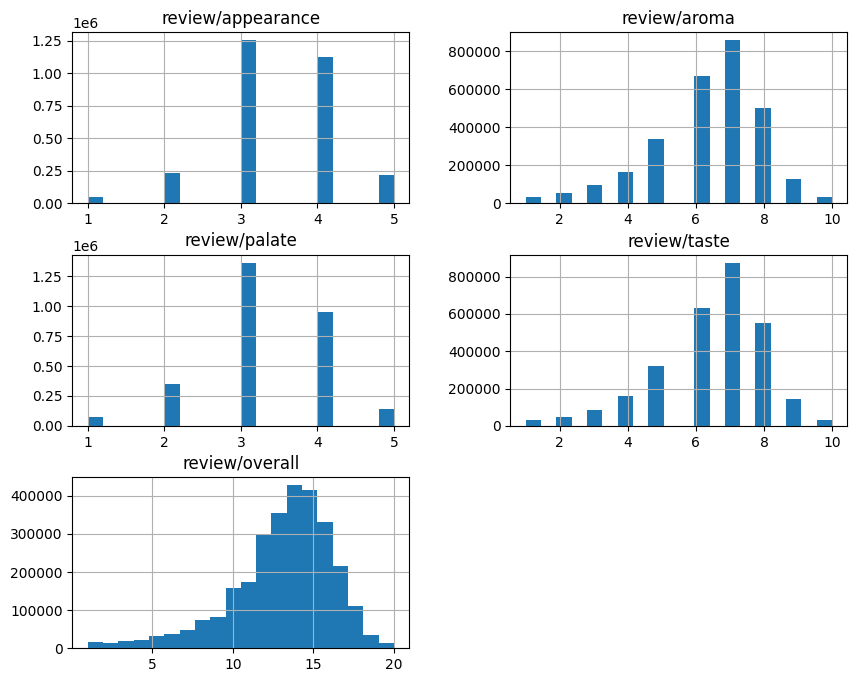

In [18]:
# Step 3: Ratings Analysis
# Convert rating columns to numeric values if they are not already
rating_columns = ['review/appearance', 'review/aroma', 'review/palate', 'review/taste', 'review/overall']
for column in rating_columns:
    data[column] = pd.to_numeric(data[column].str.split('/').str[0], errors='coerce')

# Analyze distributions of ratings
rating_distributions = data[rating_columns].hist(figsize=(10, 8), bins=20)

# Compute correlations between individual ratings and overall rating
correlations = data[rating_columns].corr()['review/overall'].drop('review/overall')

# Display the correlations
print("\nCorrelations Between Individual Ratings and Overall Rating:\n", correlations)

In [ ]:
data['beer/ABV'] = pd.to_numeric(data['beer/ABV'], errors='coerce')

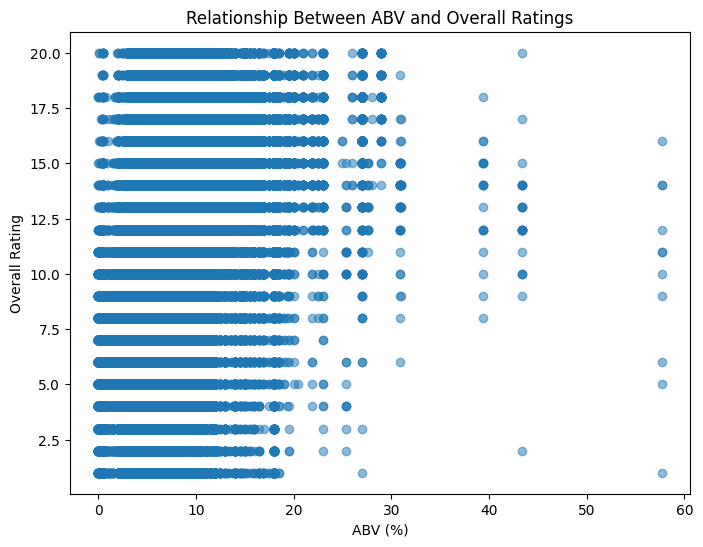


Most Common Beer Styles:
 beer/style
India Pale Ale (IPA)    183406
Pale Lager              139876
Belgian Strong Ale      122011
Imperial Stout          120710
Imperial/Double IPA     104843
Name: count, dtype: int64

Average Ratings by Beer Style:
 beer/style
Sak - Koshu            16.035714
Imperial Stout         15.852249
Ice Cider/Perry        15.810175
Abt/Quadrupel          15.660048
Imperial/Double IPA    15.452381
Name: review/overall, dtype: float64


In [25]:
# Step 4: Exploration by Category
# Most common beer styles and their average ratings
style_counts = data['beer/style'].value_counts()
style_avg_ratings = data.groupby('beer/style')['review/overall'].mean().sort_values(ascending=False)

# Relationship between ABV and overall ratings
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data['beer/ABV'], data['review/overall'], alpha=0.5)
plt.title('Relationship Between ABV and Overall Ratings')
plt.xlabel('ABV (%)')
plt.ylabel('Overall Rating')
plt.show()

# Display the most common styles and their average ratings
print("\nMost Common Beer Styles:\n", style_counts.head())
print("\nAverage Ratings by Beer Style:\n", style_avg_ratings.head())

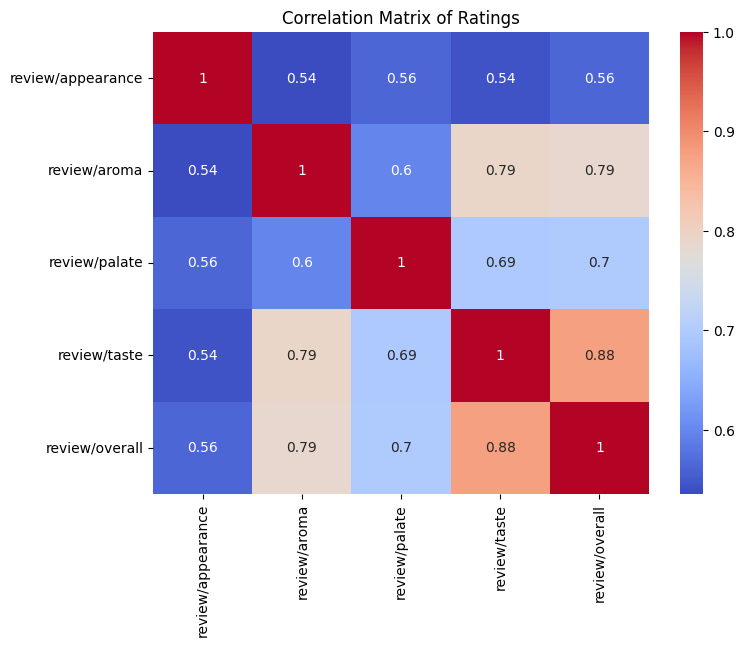

In [28]:
# Correlation matrix
corr = data[rating_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Ratings')
plt.show()

In [29]:
# User activity analysis
user_activity = data['review/profileName'].value_counts()
print(user_activity.head())

review/profileName
fonefan     16360
Ungstrup    15161
Papsoe      14166
yespr       13482
oh6gdx       9994
Name: count, dtype: int64


In [31]:
# Item popularity analysis
item_popularity = data['beer/name'].value_counts()
print(item_popularity.head())

beer/name
Guinness Draught                       3514
Pabst Blue Ribbon                      3430
Dogfish Head 90 Minute Imperial IPA    3130
Samuel Adams Boston Lager              3000
Sierra Nevada Pale Ale (Bottle)        3000
Name: count, dtype: int64


In [30]:
# Sparsity check
num_users = data['review/profileName'].nunique()
num_items = data['beer/name'].nunique()
sparsity = 1 - len(data) / (num_users * num_items)
print(f"Data sparsity: {sparsity:.2%}")

Data sparsity: 99.91%


/tmp/ipykernel_27600/1869481480.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['review/time'] = pd.to_datetime(data['review/time'], unit='s')


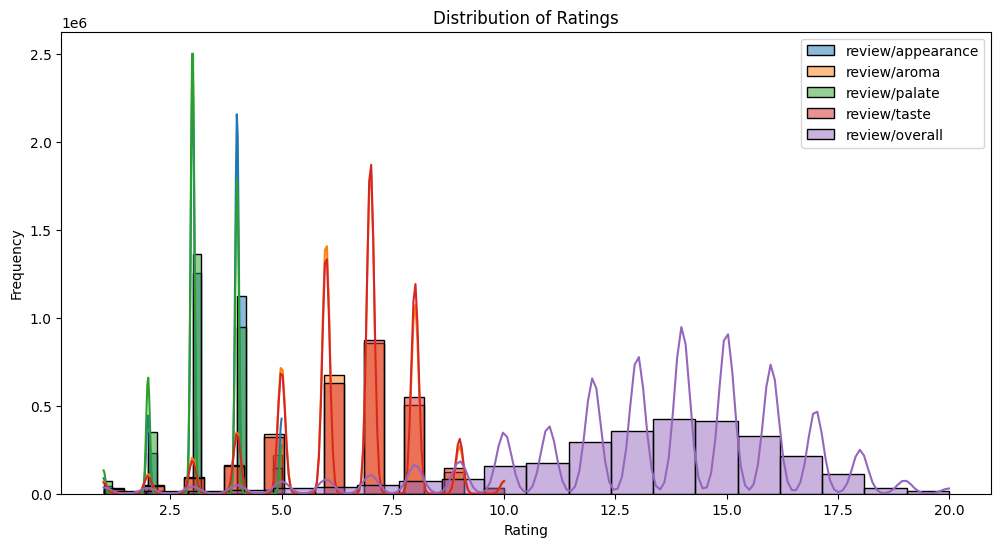

In [33]:
# Convert review time to datetime
data['review/time'] = pd.to_datetime(data['review/time'], unit='s')

# Analyze rating distributions
plt.figure(figsize=(12, 6))
for col in rating_columns:
    sns.histplot(data[col], bins=20, kde=True, label=col)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.show()

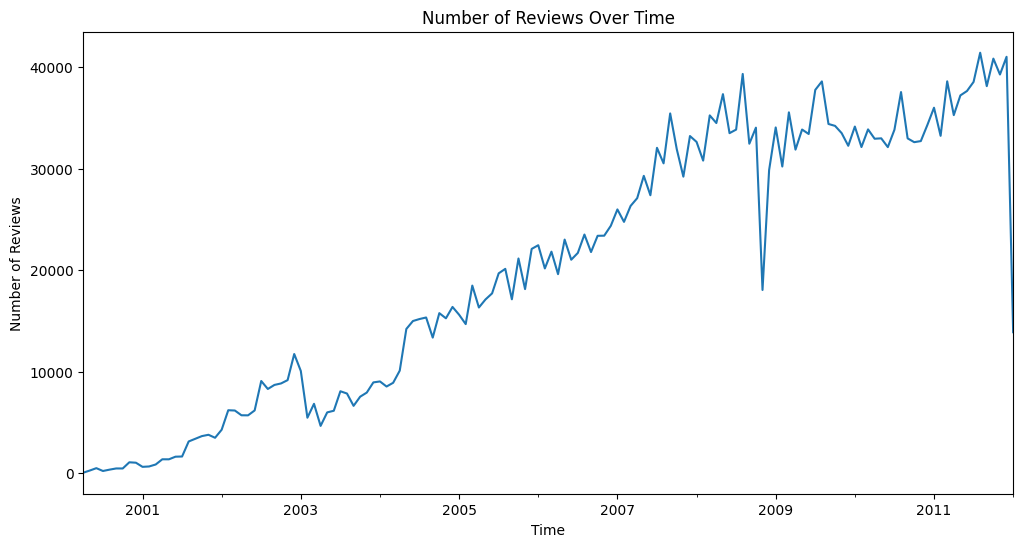

In [34]:
# Temporal analysis
plt.figure(figsize=(12, 6))
data['review/time'].dt.to_period('M').value_counts().sort_index().plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Reviews')
plt.show()

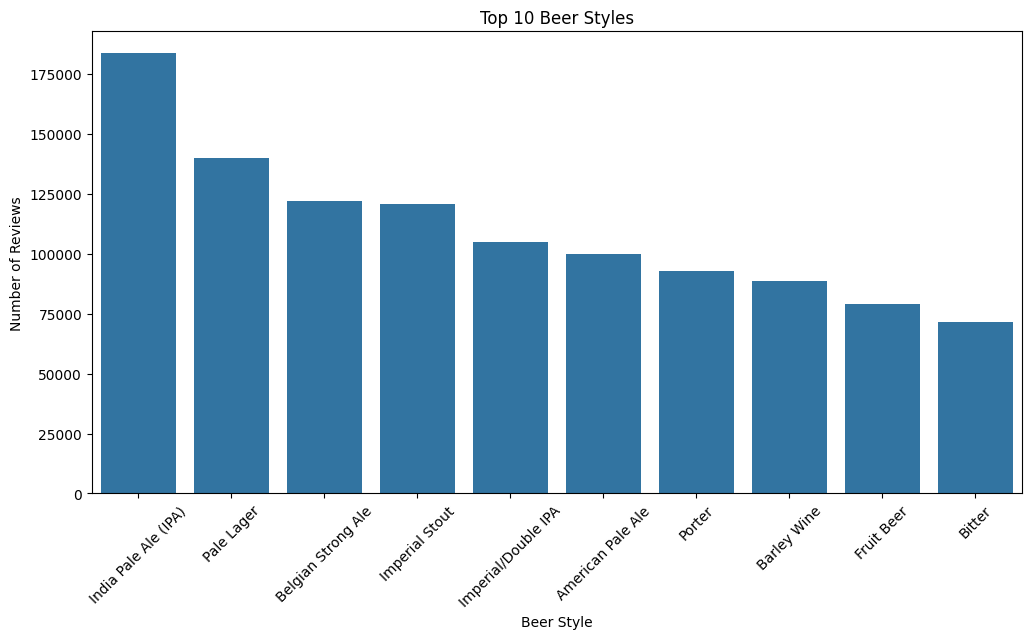

In [35]:
# Beer style analysis
top_styles = data['beer/style'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_styles.index, y=top_styles.values)
plt.xticks(rotation=45)
plt.title('Top 10 Beer Styles')
plt.xlabel('Beer Style')
plt.ylabel('Number of Reviews')
plt.show()

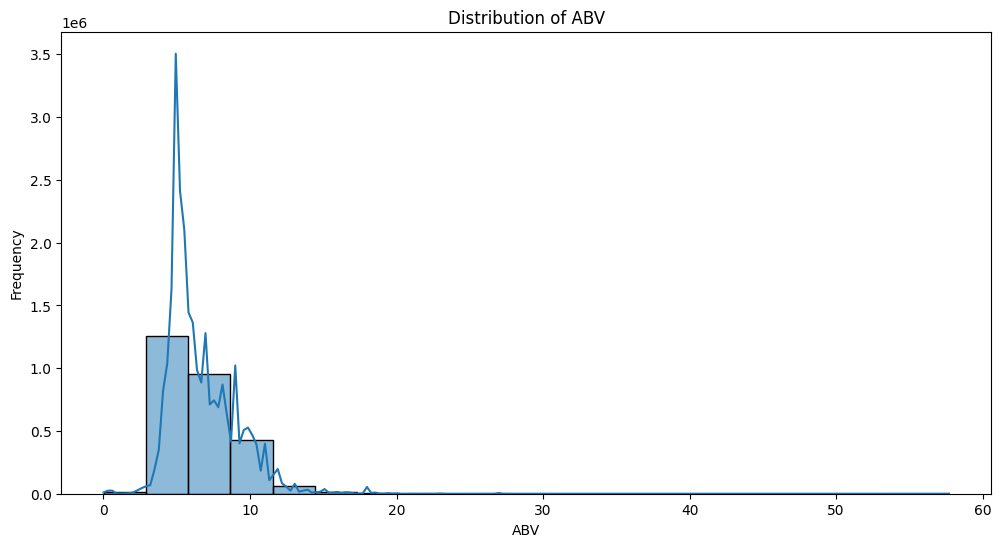

In [36]:
# ABV analysis
plt.figure(figsize=(12, 6))
sns.histplot(data['beer/ABV'].dropna(), bins=20, kde=True)
plt.title('Distribution of ABV')
plt.xlabel('ABV')
plt.ylabel('Frequency')
plt.show()

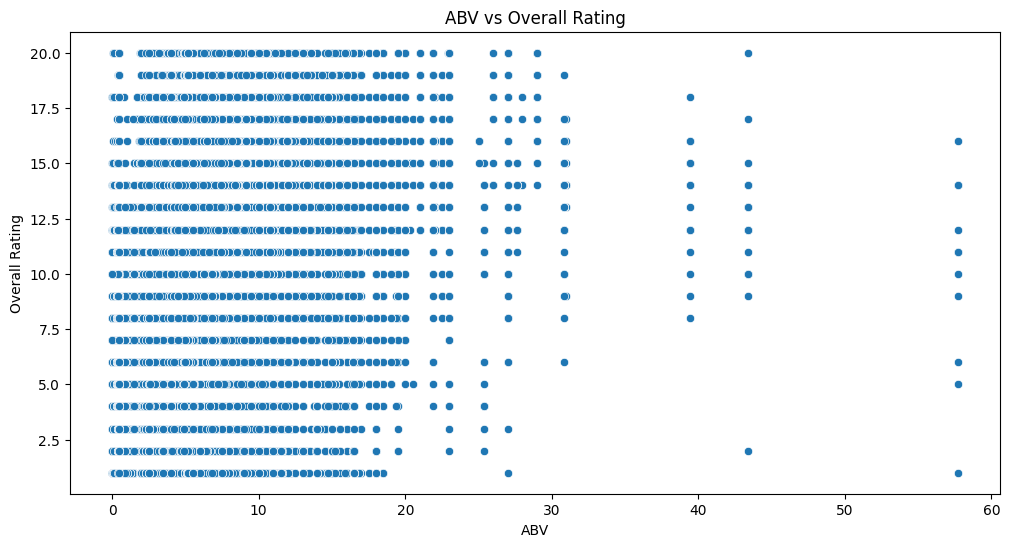

In [37]:
# ABV vs Overall Rating
plt.figure(figsize=(12, 6))
sns.scatterplot(x='beer/ABV', y='review/overall', data=data)
plt.title('ABV vs Overall Rating')
plt.xlabel('ABV')
plt.ylabel('Overall Rating')
plt.show()

In [38]:
# Brewery analysis
top_breweries = data['beer/brewerId'].value_counts().head(10)
print("Top Breweries by Number of Reviews:", top_breweries)

Top Breweries by Number of Reviews: beer/brewerId
32      45591
76      37804
198     36385
96      34139
232     31689
67      31309
84      31118
15      24819
75      23121
7043    22794
Name: count, dtype: int64


In [39]:
# User behavior analysis
user_review_counts = data['review/profileName'].value_counts()
print("User Review Counts:", user_review_counts.describe())

User Review Counts: count    29043.000000
mean        99.012636
std        461.781470
min          1.000000
25%          1.000000
50%          3.000000
75%         16.000000
max      16360.000000
Name: count, dtype: float64


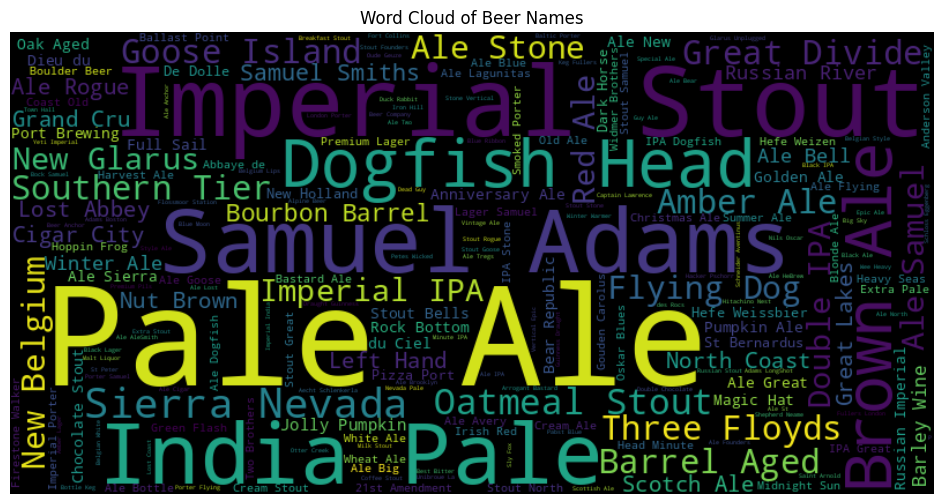

In [41]:
# Text analysis (Word Cloud for beer names)
text = ' '.join(data['beer/name'].astype(str))
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Beer Names')
plt.show()

In [42]:
# Check for non-string values in 'beer/name' column
non_string_values = data[data['beer/name'].apply(lambda x: not isinstance(x, str))]
print(non_string_values['beer/name'].head())

# Get the data types of all columns
print(data.dtypes)


2875624    NaN
Name: beer/name, dtype: object
beer/name                     object
beer/beerId                   object
beer/brewerId                 object
beer/ABV                     float64
beer/style                    object
review/appearance            float64
review/aroma                 float64
review/palate                float64
review/taste                 float64
review/overall               float64
review/time           datetime64[ns]
review/profileName            object
dtype: object


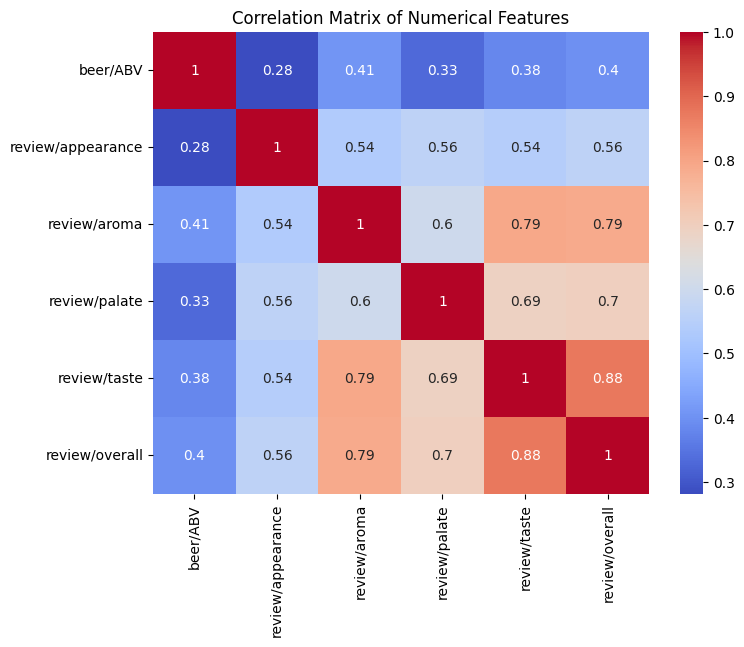

In [43]:
# Correlation analysis
corr = data[['beer/ABV'] + rating_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()